# Covid 10 data analysis
Data analysis of CountyUAs_cases_table data downloaded & timestamed daily from PHE Data hosted by ESRI at [ArcGIS.com](https://www.arcgis.com/home/item.html?id=b684319181f94875a6879bbc833ca3a6)

***
## Import python libraries and set file locations

In [1]:
## Install seaborn
#! pip install seaborn

In [43]:
### Import libraries
# For data analysis
import pandas as pd

# For downloading data from www
import urllib.request

# For finding and using file paths
import glob, os  

# For outputting Markdown formatted stuff to this notebook
from IPython.display import display, Markdown

# For plotting data
import matplotlib.pyplot as plt
import seaborn as sns

# For dates
import datetime

In [1]:
import arcpy

In [3]:
# Configure the notebook to show inline charts
%matplotlib inline

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 10)})

In [4]:
# Set file locations, using os.path.join to make the paths OS independent
onedrive_folder = os.environ['ONEDRIVECONSUMER']
root_folder = os.path.join(onedrive_folder,'Documents','COVID19')
data_folder = os.path.join(root_folder,'data')
lookup_folder = os.path.join(data_folder,'lookups')


In [5]:
# Set the prefix for the daily data files
daily_file_prefix = 'county_cases_daily'

# Set the name for the timeseries data file
timeseries_file_name = 'county_cases_timeseries.csv'

***
## Get the ONS lookup tables
The PHE data is at Local Authority District level, these lookups are used for aggregating the data into larger areas (e.g. Greater Manchester / London) 

In [6]:
# create a dictionary to store the lookup table urls
lookup_urls = {}

# Local Authority District to Combined Authority (December 2019) Lookup in England
lookup_urls['LAD_to_CA_lookup'] = 'https://opendata.arcgis.com/datasets/db4f8bae6bfa41babfafea3ec8a38c0e_0.csv'

# Local Authority District to Region (April 2019) Lookup in England
lookup_urls['LAD_to_RGN_lookup'] = 'https://opendata.arcgis.com/datasets/3ba3daf9278f47daba0f561889c3521a_0.csv'

In [7]:
# Read the lookup tables into a dictionary if they are in the lookups folder, download them first if they are not 
lookup_dataframes = {}
for (lookup_name, url) in lookup_urls.items():
    lookup_filepath = os.path.join(lookup_folder,lookup_name + '.csv')
    try:
        lookup_dataframes[lookup_name] = pd.read_csv(lookup_filepath)
    except:
        urllib.request.urlretrieve(url, lookup_filepath)
        lookup_dataframes[lookup_name] = pd.read_csv(lookup_filepath)

In [8]:
# Display the fisrt few lines of each lookup table
for (lookup_name, df_lookup) in lookup_dataframes.items():
    display(Markdown('***\n'+lookup_name))
    display(df_lookup.head())

***
LAD_to_CA_lookup

,LAD19CD,LAD19NM,CAUTH19CD,CAUTH19NM,column4,FID
0,E08000001,Bolton,E47000001,Greater Manchester,NaN,1
1,E08000002,Bury,E47000001,Greater Manchester,NaN,2
2,E08000003,Manchester,E47000001,Greater Manchester,NaN,3
3,E08000004,Oldham,E47000001,Greater Manchester,NaN,4
4,E08000005,Rochdale,E47000001,Greater Manchester,NaN,5


***
LAD_to_RGN_lookup

,LAD19CD,LAD19NM,RGN19CD,RGN19NM,FID
0,E09000001,City of London,E12000007,London,1
1,E06000054,Wiltshire,E12000009,South West,2
2,E09000002,Barking and Dagenham,E12000007,London,3
3,E09000003,Barnet,E12000007,London,4
4,E09000004,Bexley,E12000007,London,5


***
## Read the timestamped csv data files and combine them into a single timeseries

### Read the csvs

In [9]:
# Search for all the data csvs and create a list of the file paths
file_search_string = daily_file_prefix + "*.csv"
data_files = glob.glob(os.path.join(data_folder, file_search_string))

# Read each csv into a list of dataframes, then combine the list of dataframes into one dataframe
df_from_each_file = (pd.read_csv(f,index_col=0) for f in data_files)
df_combined = pd.concat(df_from_each_file, ignore_index=True,sort=False)


In [10]:
df_combined.head()

,GSS_CD,GSS_NM,TotalCases,time_stamp
0,E09000002,Barking and Dagenham,14,2020-03-19 13:55:00.000000
1,E09000003,Barnet,27,2020-03-19 13:55:00.000000
2,E08000016,Barnsley,6,2020-03-19 13:55:00.000000
3,E06000022,Bath and North East Somerset,3,2020-03-19 13:55:00.000000
4,E06000055,Bedford,1,2020-03-19 13:55:00.000000


### Fix the column names to match the ONS lookup tables

In [11]:
df_combined.rename(columns={'GSS_CD':'LAD19CD','GSS_NM':'LAD19NM'},inplace=True)

In [12]:
df_combined.head()

,LAD19CD,LAD19NM,TotalCases,time_stamp
0,E09000002,Barking and Dagenham,14,2020-03-19 13:55:00.000000
1,E09000003,Barnet,27,2020-03-19 13:55:00.000000
2,E08000016,Barnsley,6,2020-03-19 13:55:00.000000
3,E06000022,Bath and North East Somerset,3,2020-03-19 13:55:00.000000
4,E06000055,Bedford,1,2020-03-19 13:55:00.000000


### Get the actual day the data refers to from the time_stamp
The data is collected the day after it is released, so subtract 1 day from the time_stamp

In [13]:
# Convert the 'time_stamp' column to pandas datetime
df_combined['time_stamp']=pd.to_datetime(df_combined['time_stamp'])

In [14]:
# Add a column for the year
df_combined['year']=df_combined['time_stamp'].dt.year

# Add a column for the day of the year
df_combined['day']=df_combined['time_stamp'].dt.dayofyear - 1

# Combine the Year
df_combined['date']=pd.to_datetime(df_combined['year'] * 1000 + df_combined['day'], format='%Y%j')

In [15]:
# Remove the redundant 'year' and 'time_stamp' columns
df_combined.drop(['year','time_stamp'],axis=1,inplace=True)

In [16]:
df_combined.head()

,LAD19CD,LAD19NM,TotalCases,day,date
0,E09000002,Barking and Dagenham,14,78,2020-03-18
1,E09000003,Barnet,27,78,2020-03-18
2,E08000016,Barnsley,6,78,2020-03-18
3,E06000022,Bath and North East Somerset,3,78,2020-03-18
4,E06000055,Bedford,1,78,2020-03-18


### Index the data

In [17]:
# Check that the time_stamp datatype is a pandas datetime (datetime64[ns])
df_combined.dtypes

LAD19CD               object
LAD19NM               object
TotalCases             int64
day                    int64
date          datetime64[ns]
dtype: object

In [18]:
# Index the data by the LAD code and the timestamp, then sort the data
df_LAD_daily_cases = df_combined.set_index(['LAD19CD','date'])
df_LAD_daily_cases = df_LAD_daily_cases.sort_index()

In [19]:
df_LAD_daily_cases.head()

LAD19NM  TotalCases  day
LAD19CD   date                                   
E06000001 2020-03-18  Hartlepool           1   78
          2020-03-19  Hartlepool           2   79
          2020-03-20  Hartlepool           2   80
          2020-03-21  Hartlepool           2   81
          2020-03-22  Hartlepool           2   82

***
# Calculate the change in TotalCases (velocity) and change in velocity (acceleration)

In [20]:
# Calculate the velocity of the change in the number of cases from the previous time

df_LAD_daily_cases['velocity'] = df_LAD_daily_cases['TotalCases'].groupby(level=0).diff()
df_LAD_daily_cases['acceleration'] = df_LAD_daily_cases['velocity'].groupby(level=0).diff()
df_LAD_daily_cases.head()

LAD19NM  TotalCases  day  velocity  acceleration
LAD19CD   date                                                           
E06000001 2020-03-18  Hartlepool           1   78       NaN           NaN
          2020-03-19  Hartlepool           2   79       1.0           NaN
          2020-03-20  Hartlepool           2   80       0.0          -1.0
          2020-03-21  Hartlepool           2   81       0.0           0.0
          2020-03-22  Hartlepool           2   82       0.0           0.0

***
## Split out the regions

### Greater Manchester

In [21]:
# Get the Local Authority District to Combined Authority lookup table
df_LAD_to_CA_lookup = lookup_dataframes['LAD_to_CA_lookup'] 

In [22]:
# Remove redundant columns
df_LAD_to_CA_lookup.drop(['column4','FID'], axis=1, inplace=True)

In [23]:
# Filter for Greater Manchester
GM_LADs = df_LAD_to_CA_lookup[df_LAD_to_CA_lookup['CAUTH19NM']=='Greater Manchester']

In [24]:
GM_LADs

,LAD19CD,LAD19NM,CAUTH19CD,CAUTH19NM
0,E08000001,Bolton,E47000001,Greater Manchester
1,E08000002,Bury,E47000001,Greater Manchester
2,E08000003,Manchester,E47000001,Greater Manchester
3,E08000004,Oldham,E47000001,Greater Manchester
4,E08000005,Rochdale,E47000001,Greater Manchester
5,E08000006,Salford,E47000001,Greater Manchester
6,E08000007,Stockport,E47000001,Greater Manchester
7,E08000008,Tameside,E47000001,Greater Manchester
8,E08000009,Trafford,E47000001,Greater Manchester
9,E08000010,Wigan,E47000001,Greater Manchester


In [25]:
# Make a list of the Greater Manchester LAD codes
GM_LAD_codes = list(GM_LADs['LAD19CD'])

In [26]:
GM_LAD_codes

['E08000001',
 'E08000002',
 'E08000003',
 'E08000004',
 'E08000005',
 'E08000006',
 'E08000007',
 'E08000008',
 'E08000009',
 'E08000010']

In [27]:
# Filter out the GM daily case data
df_GM_LAD_cases = df_LAD_daily_cases[df_LAD_daily_cases.index.isin(GM_LAD_codes, level = 'LAD19CD')]

In [28]:
df_GM_LAD_cases.head()

LAD19NM  TotalCases  day  velocity  acceleration
LAD19CD   date                                                       
E08000001 2020-03-18  Bolton           7   78       NaN           NaN
          2020-03-19  Bolton           9   79       2.0           NaN
          2020-03-20  Bolton          13   80       4.0           2.0
          2020-03-21  Bolton          15   81       2.0          -2.0
          2020-03-22  Bolton          17   82       2.0           0.0

In [29]:
data = df_GM_LAD_cases.rename(columns={'LAD19NM':'Local Authority District','TotalCases':'Total Cases'})

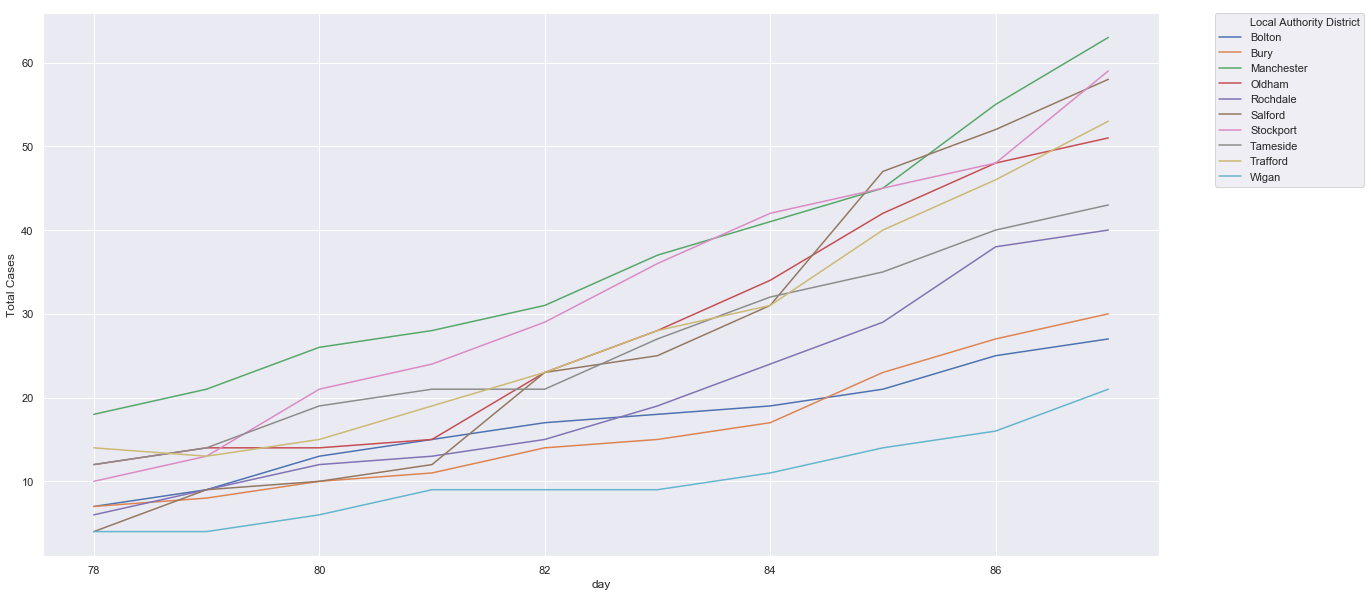

In [30]:
ax = sns.lineplot(x="day", y="Total Cases",hue="Local Authority District", data=data)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

***
# Aggregate daily data into weekly

### Create a lookup for the LAD code & name

In [31]:
# Create a lookup for the LAD code & name
df_LAD_name_lookup = df_LAD_daily_cases.reset_index()[['LAD19CD','LAD19NM']].set_index('LAD19CD').drop_duplicates()

In [32]:
df_LAD_name_lookup.head()

,LAD19NM
LAD19CD,
E06000001,Hartlepool
E06000002,Middlesbrough
E06000003,Redcar and Cleveland
E06000004,Stockton-on-Tees
E06000005,Darlington


## Agregate the data

In [33]:
df_LAD_daily_cases.head()

LAD19NM  TotalCases  day  velocity  acceleration
LAD19CD   date                                                           
E06000001 2020-03-18  Hartlepool           1   78       NaN           NaN
          2020-03-19  Hartlepool           2   79       1.0           NaN
          2020-03-20  Hartlepool           2   80       0.0          -1.0
          2020-03-21  Hartlepool           2   81       0.0           0.0
          2020-03-22  Hartlepool           2   82       0.0           0.0

In [34]:
# Aggregate the daily TotalCases to get the weekly (Monday) maximum
df_LAD_max_weekly_cases = df_LAD_daily_cases.reset_index().groupby(['LAD19CD', pd.Grouper(key='date', freq='W-MON')])['TotalCases'].max()

# Aggregate the daily velocity & acceleration to get weekly (Monday) average
df_LAD_mean_weekly_rates = df_LAD_daily_cases.reset_index().groupby(['LAD19CD', pd.Grouper(key='date', freq='W-MON')])[['velocity','acceleration']].mean()

In [36]:
# Join the max cases and mean rates back together
df_LADCD_weekly_cases = df_LAD_max_weekly_cases.to_frame().join(df_LAD_mean_weekly_rates)

In [38]:
# Add the LAD names back in
df_LAD_weekly_cases = df_LADCD_weekly_cases.reset_index().set_index('LAD19CD').join(df_LAD_name_lookup)

In [39]:
# Rename the columns
columns={'date':'week_starting','TotalCases':'max_cases','velocity':'mean_velocity','acceleration':'mean_acceleration'}
df_LAD_weekly_cases.rename(columns=columns, inplace=True)

In [40]:
# Index the data by the LAD code and the timestamp, then sort the data
df_LAD_weekly_cases = df_LAD_weekly_cases.reset_index().set_index(['LAD19CD','week_starting'])
df_LAD_weekly_cases = df_LAD_weekly_cases.sort_index()

In [41]:
df_LAD_weekly_cases.head()

max_cases  mean_velocity  mean_acceleration  \
LAD19CD   week_starting                                                
E06000001 2020-03-23             3           0.40                0.0   
          2020-03-30             6           0.75                0.5   
E06000002 2020-03-23             3           0.60                0.5   
          2020-03-30            17           3.50                1.5   
E06000003 2020-03-23             3           0.40                0.0   

                                      LAD19NM  
LAD19CD   week_starting                        
E06000001 2020-03-23               Hartlepool  
          2020-03-30               Hartlepool  
E06000002 2020-03-23            Middlesbrough  
          2020-03-30            Middlesbrough  
E06000003 2020-03-23     Redcar and Cleveland

***
## Get last full week of data

In [59]:
# Get todays date as a datetime
today = datetime.date.today()

# Get the number of days since the Monday of the last full week
days_to_subtract = today.weekday() if today.weekday()>0 else 7

# Get the date of the Monday of the last full week as a TimeStamp
last_full_week_start = pd.Timestamp(today - datetime.timedelta(days_to_subtract))

In [60]:
last_full_week_start


Timestamp('2020-03-23 00:00:00')

In [64]:
# Get the last full week's data
df_LAD_last_week_cases = df_LAD_weekly_cases.reset_index().set_index('LAD19CD')[df_LAD_last_week_cases['week_starting']==last_full_week_start]

In [65]:
df_LAD_last_week_cases.head()

,week_starting,max_cases,mean_velocity,mean_acceleration,LAD19NM
LAD19CD,,,,,
E06000001,2020-03-23,3,0.4,0.0,Hartlepool
E06000002,2020-03-23,3,0.6,0.5,Middlesbrough
E06000003,2020-03-23,3,0.4,0.0,Redcar and Cleveland
E06000004,2020-03-23,12,1.2,-0.5,Stockton-on-Tees
E06000005,2020-03-23,3,0.2,0.0,Darlington


In [66]:
# Write the data to a csv
df_LAD_last_week_cases.to_csv('LAD_last_week_cases.csv')

In [67]:
df_LAD_last_week_cases.count()

week_starting        149
max_cases            149
mean_velocity        149
mean_acceleration    149
LAD19NM              149
dtype: int64

***

In [360]:
# Get the latest timestamp
# (must be a better way to do this...)
latest_timestamp = df_LAD_daily_cases.index.to_frame()['date'].max()

In [361]:
# Get the latest day's data
df_LAD_daily_cases_latest = df_LAD_daily_cases.xs(latest_timestamp, level='date', drop_level=False)
df_LAD_daily_cases_latest.head(10)

,,LAD19NM,TotalCases,day,velocity,acceleration
LAD19CD,date,,,,,
E06000001,2020-03-27,Hartlepool,6,87,3.0,3.0
E06000002,2020-03-27,Middlesbrough,17,87,8.0,8.0
E06000003,2020-03-27,Redcar and Cleveland,13,87,3.0,3.0
E06000004,2020-03-27,Stockton-on-Tees,24,87,8.0,6.0
E06000005,2020-03-27,Darlington,11,87,6.0,5.0
E06000006,2020-03-27,Halton,10,87,2.0,2.0
E06000007,2020-03-27,Warrington,15,87,5.0,4.0
E06000008,2020-03-27,Blackburn with Darwen,7,87,1.0,-2.0
E06000009,2020-03-27,Blackpool,9,87,1.0,1.0


In [362]:
df_LAD_daily_cases_latest.describe()

,TotalCases,day,velocity,acceleration
count,149.000000,149.0,149.00000,149.000000
mean,79.006711,87.0,16.42953,5.510067
std,72.215845,0.0,16.54570,12.791265
min,0.000000,87.0,0.00000,-20.000000
25%,26.000000,87.0,5.00000,-1.000000
50%,54.000000,87.0,12.00000,3.000000
75%,115.000000,87.0,23.00000,9.000000
max,366.000000,87.0,129.00000,104.000000


In [363]:
# Top 10 TotalCases
df_LAD_daily_cases_latest.sort_values('TotalCases',ascending=False).head(10)

,,LAD19NM,TotalCases,day,velocity,acceleration
LAD19CD,date,,,,,
E08000025,2020-03-27,Birmingham,366,87,76.0,14.0
E10000014,2020-03-27,Hampshire,317,87,50.0,34.0
E09000028,2020-03-27,Southwark,290,87,37.0,-7.0
E08000019,2020-03-27,Sheffield,286,87,46.0,-20.0
E09000022,2020-03-27,Lambeth,276,87,28.0,-8.0
E10000030,2020-03-27,Surrey,271,87,129.0,104.0
E09000005,2020-03-27,Brent,265,87,37.0,1.0
E09000032,2020-03-27,Wandsworth,228,87,24.0,4.0
E09000008,2020-03-27,Croydon,219,87,38.0,20.0


In [365]:
# Top 10 velocity
df_LAD_daily_cases_latest[df_LAD_daily_cases_latest['velocity'].notna()].sort_values('velocity',ascending=False).head(10)

,,LAD19NM,TotalCases,day,velocity,acceleration
LAD19CD,date,,,,,
E10000030,2020-03-27,Surrey,271,87,129.0,104.0
E08000025,2020-03-27,Birmingham,366,87,76.0,14.0
E10000016,2020-03-27,Kent,182,87,70.0,54.0
E10000014,2020-03-27,Hampshire,317,87,50.0,34.0
E08000019,2020-03-27,Sheffield,286,87,46.0,-20.0
E09000009,2020-03-27,Ealing,209,87,44.0,15.0
E08000021,2020-03-27,Newcastle upon Tyne,121,87,41.0,19.0
E10000002,2020-03-27,Buckinghamshire,106,87,40.0,33.0
E09000006,2020-03-27,Bromley,188,87,39.0,15.0


In [366]:
acceleration_notna_mask = df_LAD_daily_cases_latest['acceleration'].notna()

In [367]:
# Top 10 acceleration
df_LAD_daily_cases_latest[acceleration_notna_mask].sort_values('acceleration',ascending=False).head(10)

,,LAD19NM,TotalCases,day,velocity,acceleration
LAD19CD,date,,,,,
E10000030,2020-03-27,Surrey,271,87,129.0,104.0
E10000016,2020-03-27,Kent,182,87,70.0,54.0
E06000039,2020-03-27,Slough,59,87,37.0,37.0
E10000014,2020-03-27,Hampshire,317,87,50.0,34.0
E10000002,2020-03-27,Buckinghamshire,106,87,40.0,33.0
E08000024,2020-03-27,Sunderland,55,87,28.0,26.0
E08000028,2020-03-27,Sandwell,103,87,38.0,23.0
E06000047,2020-03-27,County Durham,56,87,27.0,23.0
E06000040,2020-03-27,Windsor and Maidenhead,37,87,23.0,22.0


In [368]:
# Bottom 10 acceleration
df_LAD_daily_cases_latest[acceleration_notna_mask].sort_values('acceleration',ascending=True).head(10)

,,LAD19NM,TotalCases,day,velocity,acceleration
LAD19CD,date,,,,,
E08000019,2020-03-27,Sheffield,286,87,46.0,-20.0
E09000012,2020-03-27,Hackney and City of London,134,87,15.0,-19.0
E09000023,2020-03-27,Lewisham,158,87,14.0,-16.0
E09000011,2020-03-27,Greenwich,128,87,10.0,-11.0
E09000016,2020-03-27,Havering,82,87,12.0,-11.0
E09000004,2020-03-27,Bexley,85,87,8.0,-10.0
E09000002,2020-03-27,Barking and Dagenham,82,87,10.0,-9.0
E09000022,2020-03-27,Lambeth,276,87,28.0,-8.0
E09000018,2020-03-27,Hounslow,126,87,14.0,-8.0
